## Detection of size of body parts
In this project we are going to use, image processing to calculate the size of body parts(shoulders), from the images and then predict the shirt size for the person.

This Notebook is divided into parts-
1. Crop the images into suitable size
2. Image Segmentation
3. Calcuate the distances between the extreme points
4. Predict the shoulder width

In [3]:
import numpy as np
import cv2 as cv
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model

We have made a dataset which contains images clicked as-
- Distance between the subject and camera is approx. 75cm
- Distance between the subject and camera is approx. 100cm
- Distance between the subject and camera is approx. 200cm

Nomenclature- 75cm: img75-1;
              100cm: img100-1;
              200cm: img200-1;
where 1 is the number assigned to the subject

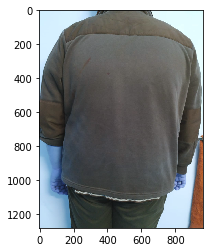

In [4]:
image = cv.imread("shirtSize/img75-21.jpeg")
plt.imshow(image)

In [5]:
image.shape

(1280, 960, 3)

In [6]:
def crop_bottom_half(image):
#         x1=image.shape[0]*1/4
        x1=image.shape[0]*4/9
        x2=image.shape[0]
        y2=image.shape[1]
#         print(x1," height= ",x2," width= ",y2)
#         cropped_img = image(Rect(0, image.rows/2, image.cols, image.rows/2))
        cropped_img = image[0:int(x1),0:int(y2)]
        #print("cropped_img")
        #print("height=",cropped_img.shape[0]," width=",cropped_img.shape[1])
        return cropped_img

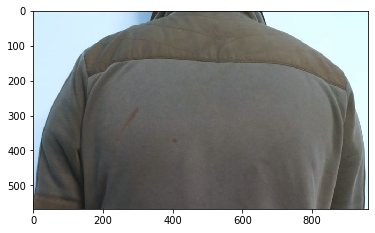

In [7]:
cropimg = crop_bottom_half(image)
plt.imshow(cropimg)

In [8]:
def crop_twobynine(image):
        x1=image.shape[0]*2/9
        x2=image.shape[0]
        y2=image.shape[1]
        #print(x1," height= ",x2," width= ",y2)
        #cropped_img = image(Rect(0, image.rows/2, image.cols, image.rows/2))
        cropped_img = image[0:int(x1),0:int(y2)]
        #print("cropped_img")
        #print("height=",cropped_img.shape[0]," width=",cropped_img.shape[1])
        return cropped_img

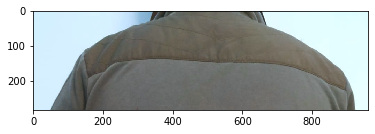

In [9]:
cropimg_1 = crop_twobynine(image)
plt.imshow(cropimg_1)

Now that, we have a cropped image according to what we need.
We are going to do some image segmenatation.

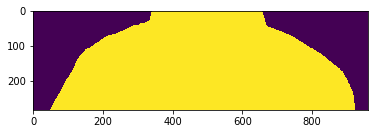

In [10]:
cropped = cv.GaussianBlur(cropimg_1, (5,5),0)
gray = cv.cvtColor(cropped, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(gray, 0, 255,cv.THRESH_BINARY_INV + cv.THRESH_OTSU )
plt.imshow(thresh)

Pretty good result, in the first operation itself.
Let's try and enhance it further to get the edges using Canny Edge Detection.

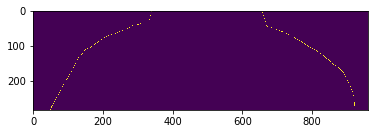

In [11]:
kernel = np.ones((5,5),np.uint8)
closing = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
edges = cv.Canny(closing,100,200)
plt.imshow(edges)

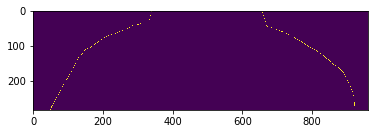

In [12]:
kernel = np.ones((5,5),np.uint8)
opening = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
edges_o = cv.Canny(opening,100,200)
plt.imshow(edges_o)

This is some neat edge detection.
So, what's the next step?
Let's calculate the distance between the extreme points.
Oh!wait....let's first find the extreme points

872.0005733943069


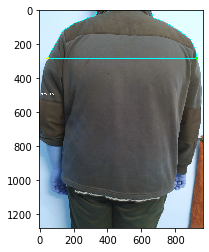

In [13]:
from scipy.spatial import distance as dist
import imutils

cnts = cv.findContours(thresh.copy(), cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv.contourArea)

# determine the most extreme points along the contour
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

#dB1 = dist.euclidean((extLeft[0], extRight[0]), (extLeft[1], extRight[1]))
#print("left: ",extLeft," right: ",extRight)

dB = dist.euclidean(extLeft,extRight)
dB = dist.euclidean(extLeft,extRight)

#dB = dist.euclidean(extLeft,extBot)
#print(dB," ",dB1)
print(dB)

cv.putText(image, "{:.1f}in".format(dB),
         (10,500), cv.FONT_HERSHEY_SIMPLEX, 0.65, (255, 255, 255), 2)

# draw the outline of the object, then draw each of the
# extreme points, where the left-most is red, right-most
# is green, top-most is blue, and bottom-most is teal
cv.drawContours(image, [c], -1, (0, 255, 255), 2)
cv.circle(image, extLeft, 8, (0, 0, 255), -1)
cv.circle(image, extRight, 8, (0, 255, 0), -1)
cv.circle(image, extTop, 8, (255, 0, 0), -1)
cv.circle(image, extBot, 8, (255, 255, 0), -1)
plt.imshow(image)

Now that we have the extreme points, and also the distance between them.
Now, comes the part of prediction. Just a linear regression model will suffice for the prediction part.

The 'Book.csv' has the data to feed to our regression model.
Format of data:
- s.no.
- W75 => calculated pixel length between extreme points of the image taken from 75 cm
- width75 => Width of the image taken from 75 cm dist.
- ratio75 => W75 % width75
- W100 => calculated pixel length between extreme points of the image taken from 100 cm
- width100 => Width of the image taken from 100 cm dist.
- ratio100 => W100 % width100
- W150 => calculated pixel length between extreme points of the image taken from 150 cm
- width150 => Width of the image taken from 150 cm dist.
- ratio150 => W150 % width150
- Actual (in cm)

In [14]:
import pandas as pd
import seaborn as sns
import sklearn.preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import sklearn.metrics as m

In [15]:
df = pd.read_csv("book.csv")
Y=df[["Actual (in cm)"]]
z=df[["ratio75"]] # for multiple linear regression

predict = z.iloc[32:40,]

vector = Y.iloc[0:32,]
poly = PolynomialFeatures(degree=2)
x = z.iloc[0:32,]

X_ = poly.fit_transform(x)
predict_ = poly.fit_transform(predict)
clf = sklearn.linear_model.LinearRegression()
clf.fit(X_, vector)
Yhat=clf.predict(predict_)
print("predicted values")
print(Yhat)
print("--------------------------")

predicted values
[[46.69967479]
 [46.63894653]
 [45.91534883]
 [46.69342722]
 [46.60964232]
 [46.27302461]
 [43.94456249]]
--------------------------


-0.922745275314425
12.870621434757783


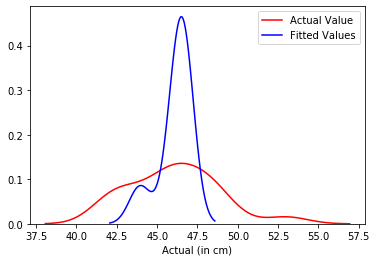

In [16]:
print(m.r2_score(Y[32:40],Yhat))
print(m.mean_squared_error(Y[32:40],Yhat))
ax1 = sns.distplot(df['Actual (in cm)'], hist=False, color="r", label="Actual Value")
sns.distplot(Yhat, hist=False, color="b", label="Fitted Values" , ax=ax1)#Yhat is given as a predicted values (calculated before)
plt.show()